# Setuo and importing

In [1]:
from utils import *

setup_notebook()

Using transformers v4.25.1
Using datasets v2.11.0


In [2]:
!apt-get install -qq git-lfs

import os
os.environ['TOKENIZERS_PARALLELISM']='false'

import warnings, logging
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

# Understanding QA models

In [3]:
from transformers import AutoTokenizer

model_ckpt='timpal0l/mdeberta-v3-base-squad2'
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

In [4]:
question="Kitob nechta ertakni o'z ichiga olgan?"

context="""Har bir ertak taxminan 20 bet, demak 6 ta atrofida."""
inputs = tokenizer(question, context, return_tensors="pt")

In [5]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 0.5172, -4.3441,
-5.9494, -7.2650, -8.1800, -6.0313, -7.6376, -7.1800,
         -8.3940, -6.6228, -5.4741, -8.2812, -7.6467, -6.7636, -7.2952, -6.1489,
         -5.7124, -4.9122,  1.6223, -2.3908, -1.5162, -4.8480, -0.0995, -5.5776,
          1.6068, -2.8450, -4.3370, -2.2788, -5.3245,  4.8877, -3.9196, -6.9470,
         -5.2992, -6.2171, -4.6565, -6.2596]]), end_logits=tensor([[ 0.6851,
-6.1655, -4.0074, -8.2618, -5.5342, -7.8061, -6.2753, -5.1088,
         -6.5025, -8.4469, -4.9712, -7.3006, -7.6850, -6.2573, -7.1274, -5.1988,
         -4.7574, -6.4330, -3.1207, -1.6069, -5.0678,  0.3288, -5.2143, -5.6684,
          1.3895,  0.6635, -0.9423, -5.5520, -5.0273,  4.6625,  3.0775, -2.5707,
         -2.5025,  1.0708,  1.0506, -6.3434]]), hidden_states=None,
attentions=None)


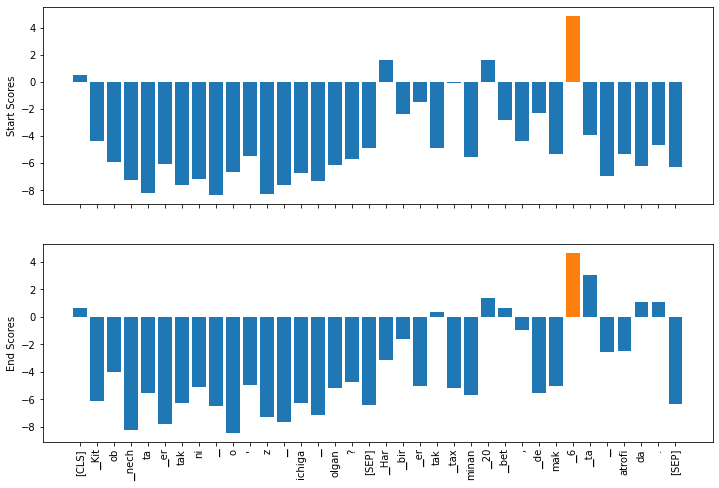

In [6]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

In [7]:
start_idx = torch.argmax(start_logits)  
end_idx = torch.argmax(end_logits) + 1  
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: Kitob nechta ertakni o'z ichiga olgan?
Answer: 6


# Why we need retriever

In [8]:
if not os.path.exists('elasticsearch-7.9.2'):
    ! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
    ! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
    ! chown -R daemon:daemon elasticsearch-7.9.2

In [9]:
%%bash --bg

sudo -u daemon -- elasticsearch-7.9.2/bin/elasticsearch

In [10]:
import time

time.sleep(30)

In [11]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "nsh6lp2hal",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "84RYn7Q3Rr-3lyKlq_dCdw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [12]:
from haystack.document_stores import ElasticsearchDocumentStore

host=os.environ.get("ELASTICSEARCH_HOST", "localhost")
document_store=ElasticsearchDocumentStore(
    host=host,
    port=9200,
    username="elastic",
    password="32HKbWu8IFllgjU67oLNWQfz",
    index='documents'
)

In [13]:
print(f"We have {document_store.get_document_count()} documents i document store.")

We have 2981 documents i document store.


In [14]:
from haystack.nodes import FARMReader

max_seq_length, doc_stride=384, 128

reader=FARMReader(model_name_or_path='mdeberta-model',
                  progress_bar=False,
                  max_seq_len=max_seq_length,
                  doc_stride=doc_stride,
                  return_no_answer=True)

In [15]:
from time import time
import pandas as pd

df=pd.read_csv('data/books.csv')
docs=[row['description'] for _,row in df.drop_duplicates(subset='title').iterrows()]

question="O'qishga qaysi romanni tafsiya qilasiz?"

In [16]:
# Measure the time it takes to read documents
start = time()
reader.predict_on_texts(question=question, texts=docs, top_k=1)
end = time()
reader_time=end-start
print(f"Time taken to read documents: {reader_time} seconds.")

Time taken to read documents: 165.86813831329346 seconds.


In [17]:
from haystack.pipelines import ExtractiveQAPipeline
from haystack.nodes import BM25Retriever

bm25_retriever=BM25Retriever(document_store=document_store)
pipe=ExtractiveQAPipeline(reader, bm25_retriever)

In [22]:
start=time()
preds=pipe.run(query=question, params={"Retriever": {"top_k": 3}, 
                                      "Reader": {"top_k": 1}})
end = time()
pipeline_time=end-start
print(f"Time taken to execute the pipeline: {pipeline_time} seconds.")

Time taken to execute the pipeline: 0.14533638954162598 seconds.


In [23]:
print(f"We have {reader_time/pipeline_time} times improvement from executing retriever.")

We have 1141.2705299507043 times improvement from executing retriever.
